# C-c C-v from the other file :)

In [82]:
import numpy as np
import math
# import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Input, MaxPooling2D, Add, GlobalAveragePooling2D, Reshape, Bidirectional, Dense, Flatten, Dropout, SpatialDropout2D
from keras.layers import LSTM, RepeatVector, Concatenate, Lambda, ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow import concat, constant, shape, fill
from tensorflow.math import exp, log
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import librosa
import soundfile as sf
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

In [3]:
class ResNetLstm():
    """
    Usage: 
        sr = ResNetLstm([4,8,16], input_size=(50,50,1), output_size=12)
        sr.build()
        followed by sr.m.compile(loss='categorical_crossentropy', 
                                 optimizer='adadelta', metrics=["accuracy"])
        save plotted model with: 
            keras.utils.plot_model(sr.m, to_file = '<location>.png', 
                                   show_shapes=True)
    """
    def __init__(self,
                 filters_list=[], 
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.filters_list = filters_list
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None        
    
    def _block(self, filters, inp):
        """ one residual block in a ResNetLstm
        
        Args:
            filters (int): number of convolutional filters
            inp (tf.tensor): output from previous layer
            
        Returns:
            tf.tensor: output of residual block
        """
        layer_1 = BatchNormalization()(inp)
        act_1 = Activation('relu')(layer_1)
        conv_1 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_1)
        layer_2 = BatchNormalization()(conv_1)
        act_2 = Activation('relu')(layer_2)
        conv_2 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_2)
        return(conv_2)
    def build(self):
        """
        Returns:
            keras.engine.training.Model
        """

        print('1shapes: ', self.input_size)
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(self.filters_list[0], (3,3), 
                   padding = 'same',
                   kernel_initializer = self.initializer)(i)
        print('2shapes: ', x.shape)
        x = MaxPooling2D((1,3))(x)
        # x = MaxPooling2D(padding = 'same')(x)
        print('3shapes: ', x.shape)
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        if len(self.filters_list) > 1:
            for filt in self.filters_list[1:]:
                print(filt)
                x = Conv2D(filt, (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = self.initializer)(x)
                x = MaxPooling2D((1,3))(x)
                print('6shapes: ', x.shape)
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
        # x = GlobalAveragePooling2D()(x)
        
        x = Reshape((85,4*32))(x)
        print('7shapes: ', x.shape)
        x = Bidirectional(LSTM(64,return_sequences=True))(x)
        print('8shapes: ', x.shape)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Bidirectional(LSTM(32,return_sequences=True))(x)
        print('9shapes: ', x.shape)
        x = Reshape((85,2*32))(x)
        print('0shapes: ', x.shape)
        print('output_size: ', self.output_size)
        x = Flatten()(x)
        print('1shapes: ', x.shape)
        x = Dropout(0.2)(x)
        
        x = Dense(self.output_size, activation = 'softmax')(x)
        print('2shapes: ', x.shape)
        
        self.m = Model(i,x)
        return self.m

In [4]:
# path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/'
path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
X_train = np.load(path+'data/X_train.npy').transpose((0,2,1,3))
Y_train = np.load(path+'data/Y_train.npy')
#X_train = X_train[1::20, ...]
#Y_train = Y_train[1::20, ...]
X_val = np.load(path+'data/X_val.npy').transpose((0,2,1,3))
Y_val = np.load(path+'data/Y_val.npy')

In [5]:
# This is augumentation, I don't know if we want to keep this. For now, let's comment it out
#X_train_flipped = np.flip(X_train, 2)
#Y_train_flipped = Y_train.copy()
#Y_train_flipped[Y_train != 10] = 11
#X_train = np.append(X_train, X_train_flipped, 0)
#Y_train = np.append(Y_train, Y_train_flipped)

In [6]:
path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
# path = '/dev/shm/kmrozowski/'
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir(path + 'data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
classes_known = classes[:-1]
print(all_classes, '-->', classes_known)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero'] --> ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']


In [7]:
def binarize_classes(set, target):
    ret = set.copy()
    for i, class_idx in enumerate(ret):
        if classes[class_idx] == target:
            ret[i] = 1
        else:
            ret[i] = 0
    return ret

In [8]:
def get_class_weights(set):
   counter = Counter(set)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}

In [9]:
input_size = X_train.shape[1:]
batch_size = 196

In [10]:
filters_list = [8,16,32]
output_size_binary = 2

In [11]:
#adjust these strings for organizeing the saved files
date = '20220502'
arch_without_suffix = 'resnetlstm8_16_32_binary_'

In [12]:
def step_decay(epoch):
   initial_lrate = 0.4
   # drop = 0.5
   # epochs_drop = 10.0
   fastest_decay_epicentrum = 600
   epochs_of_fast_decaying = 200
   lrate = initial_lrate * (math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying) + 0.915 * math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate


v = np.arange(1,200,1)
w = [step_decay(x) for x in v]
print(w[-1])

0.346177849024205


In [12]:
sr = {}
for target in classes_known:
    print(target)
    arch = arch_without_suffix + target
    sr[target] = ResNetLstm(filters_list, input_size, output_size_binary)
    sr[target].build()
    sr[target].m.compile(loss='categorical_crossentropy', 
                         optimizer=Adadelta(learning_rate=1.0,
                                            rho=0.95,
                                            epsilon=1e-07,
                                            name="Adadelta"),
                         metrics=['accuracy'])
    plot_model(sr[target].m,
               to_file = './models/{}_{}.png'.format(arch,date), 
               show_shapes = True)
    Y_train_target = binarize_classes(Y_train, target)
    Y_val_target = binarize_classes(Y_val, target)
    checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                                   verbose=0,
                                   save_best_only=True)
    earlystopping = EarlyStopping()
    tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                              histogram_freq = 0, 
                              write_graph = True, 
                              write_images = True)
    sheluder = LearningRateScheduler(step_decay, verbose=0)
    print(get_class_weights(Y_train_target))
    history = sr[target].m.fit(X_train, 
                               to_categorical(Y_train_target),
                               batch_size = batch_size,
                               #epochs = 1000,
                               epochs = 3,
                               verbose = 1, shuffle = True, 
                               class_weight = get_class_weights(Y_train_target),
                               validation_data = (X_val, to_categorical(Y_val_target)), 
                               callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want
    val_pred = sr[target].m.predict(X_val, batch_size = batch_size, verbose = 1)
    print(classification_report(Y_val_target, np.argmax(val_pred, axis = 1), target_names = ["0", "1"], digits = 3))

yes
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)


2022-05-07 20:49:07.468062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 20:49:07.468124: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 20:49:07.468137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (blue): /proc/driver/nvidia/version does not exist
2022-05-07 20:49:07.468283: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)
{0: 1.0, 1: 26.544423440453688}
Epoch 1/3


2022-05-07 20:49:09.399219: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2417620320 exceeds 10% of free system memory.


298/298 [==============================] - 307s 1s/step - loss: 0.5309 - accuracy: 0.8833 - val_loss: 0.1352 - val_accuracy: 0.9670 - lr: 0.3653
Epoch 2/3
298/298 [==============================] - 289s 968ms/step - loss: 0.2190 - accuracy: 0.9622 - val_loss: 0.0593 - val_accuracy: 0.9775 - lr: 0.3653
Epoch 3/3
35/35 [==============================] - 8s 193ms/step
              precision    recall  f1-score   support

           0      0.998     0.977     0.987      6578
           1      0.623     0.954     0.753       261

    accuracy                          0.976      6839
   macro avg      0.810     0.966     0.870      6839
weighted avg      0.984     0.976     0.979      6839

no
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2

2022-05-07 21:04:07.734627: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2417620320 exceeds 10% of free system memory.


298/298 [==============================] - 300s 992ms/step - loss: 0.8230 - accuracy: 0.7867 - val_loss: 0.7409 - val_accuracy: 0.5222 - lr: 0.3653
Epoch 2/3
298/298 [==============================] - 287s 962ms/step - loss: 0.3447 - accuracy: 0.9251 - val_loss: 0.2569 - val_accuracy: 0.8886 - lr: 0.3653
Epoch 3/3
35/35 [==============================] - 8s 196ms/step
              precision    recall  f1-score   support

           0      0.992     0.979     0.986      6569
           1      0.619     0.811     0.702       270

    accuracy                          0.973      6839
   macro avg      0.805     0.895     0.844      6839
weighted avg      0.977     0.973     0.975      6839

up
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None

2022-05-07 21:18:53.935363: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2417620320 exceeds 10% of free system memory.


298/298 [==============================] - 298s 983ms/step - loss: 0.5943 - accuracy: 0.8584 - val_loss: 0.1485 - val_accuracy: 0.9586 - lr: 0.3653
Epoch 2/3
298/298 [==============================] - 289s 968ms/step - loss: 0.3543 - accuracy: 0.9234 - val_loss: 0.1811 - val_accuracy: 0.9254 - lr: 0.3653
Epoch 3/3
35/35 [==============================] - 8s 192ms/step
              precision    recall  f1-score   support

           0      0.990     0.982     0.986      6579
           1      0.621     0.762     0.684       260

    accuracy                          0.973      6839
   macro avg      0.806     0.872     0.835      6839
weighted avg      0.976     0.973     0.975      6839

down
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (No

2022-05-07 21:33:39.189186: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2417620320 exceeds 10% of free system memory.


298/298 [==============================] - 295s 974ms/step - loss: 0.7458 - accuracy: 0.8209 - val_loss: 0.3204 - val_accuracy: 0.9487 - lr: 0.3653
Epoch 2/3
298/298 [==============================] - 287s 962ms/step - loss: 0.3612 - accuracy: 0.9250 - val_loss: 0.1226 - val_accuracy: 0.9507 - lr: 0.3653
Epoch 3/3
35/35 [==============================] - 8s 195ms/step
              precision    recall  f1-score   support

           0      0.996     0.958     0.976      6575
           1      0.460     0.902     0.609       264

    accuracy                          0.955      6839
   macro avg      0.728     0.930     0.793      6839
weighted avg      0.975     0.955     0.962      6839

left
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (No

2022-05-07 21:48:20.773419: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2417620320 exceeds 10% of free system memory.


298/298 [==============================] - 299s 988ms/step - loss: 0.9104 - accuracy: 0.7709 - val_loss: 0.1512 - val_accuracy: 0.9639 - lr: 0.3653
Epoch 2/3
298/298 [==============================] - 314s 1s/step - loss: 0.4848 - accuracy: 0.8941 - val_loss: 0.0780 - val_accuracy: 0.9718 - lr: 0.3653
Epoch 3/3
35/35 [==============================] - 8s 193ms/step
              precision    recall  f1-score   support

           0      0.999     0.852     0.919      6592
           1      0.197     0.972     0.328       247

    accuracy                          0.856      6839
   macro avg      0.598     0.912     0.623      6839
weighted avg      0.970     0.856     0.898      6839

right
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None

# Combined model

In [42]:
# To load models from file :)
sr = {}
for target in classes_known:
    arch = arch_without_suffix + target
    sr[target] = ResNetLstm(filters_list, input_size, output_size_binary)
    sr[target].build()
    sr[target].m.load_weights('./models/{}_{}_best.h5'.format(arch, date))

1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)
1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shap

In [43]:
for target in classes_known:
    sr[target].m.trainable = False

In [84]:
i = Input(shape = input_size, name = 'input')
xs = {}
for target in classes_known:
    xs[target] = sr[target].m(i)[:, 1]
    xs[target] = Reshape((1,))(xs[target])
xs_known = Concatenate(axis=1)(xs.values())
xs_all = Lambda(lambda x: concat([x, fill((shape(x)[0], 1), 0.5)], 1))(xs_known)
xs_all = Activation('softmax')(xs_all)
final_model = Model(i, xs_all)

In [85]:
# Is this even needed?
final_model.compile(loss='categorical_crossentropy', 
                    optimizer=Adadelta(learning_rate=1.0,
                                       rho=0.95,
                                       epsilon=1e-07,
                                       name="Adadelta"),
                    metrics=['accuracy'])

In [86]:
#adjust these strings for organizeing the saved files
arch = 'resnetlstm8_16_32_combined'

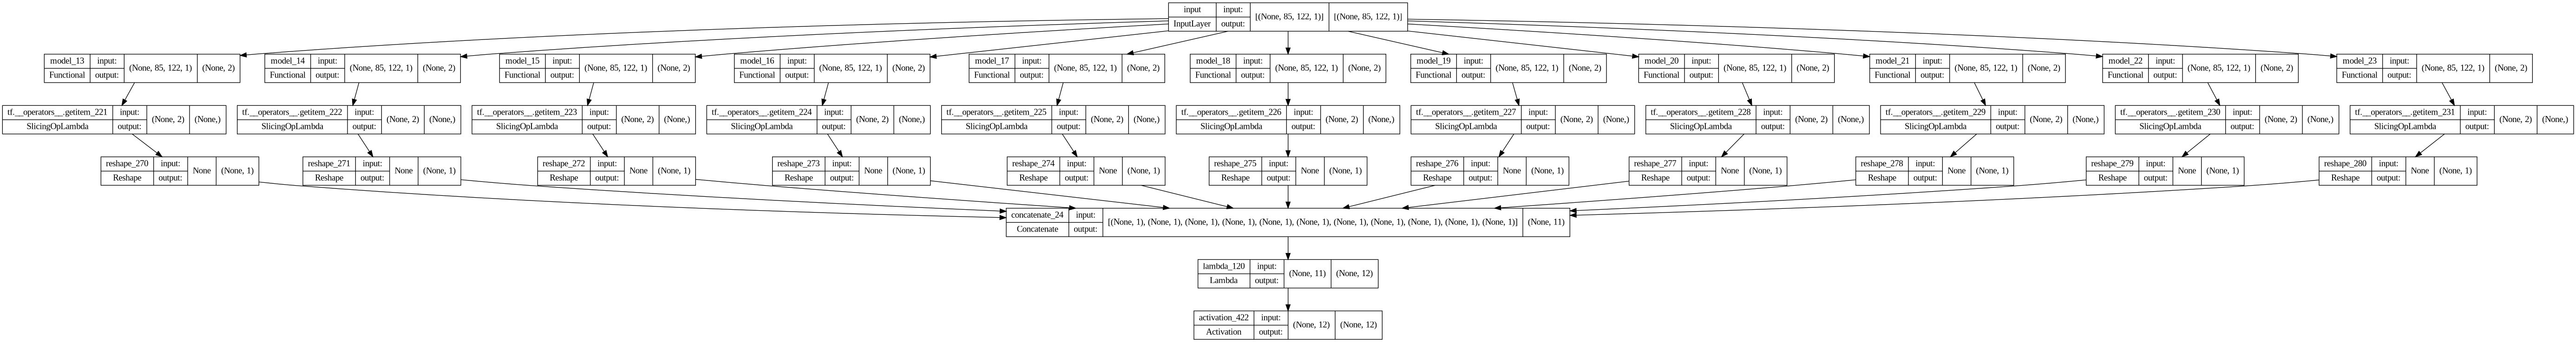

In [87]:
# So ugly!
plot_model(final_model,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

Nothing to fit here!

# Testing blablabla

In [88]:
val_pred = final_model.predict(X_val, batch_size = batch_size, verbose = 1)

35/35 [==============================] - 76s 2s/step


In [89]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

              precision    recall  f1-score   support

         yes      0.739     0.935     0.826       261
          no      0.716     0.756     0.735       270
          up      0.720     0.712     0.716       260
        down      0.538     0.848     0.659       264
        left      0.783     0.773     0.778       247
       right      0.612     0.898     0.728       256
          on      0.706     0.047     0.088       257
         off      0.467     0.906     0.616       256
        stop      0.418     0.504     0.457       246
          go      0.719     0.612     0.661       260
     silence      0.833     0.976     0.899        41
     unknown      0.895     0.817     0.854      4221

    accuracy                          0.774      6839
   macro avg      0.679     0.732     0.668      6839
weighted avg      0.800     0.774     0.769      6839



In [90]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[ 244    3    0    3    1    0    0    0    1    0    0    9]
 [   3  204    3    4    0    0    0    0    1   15    0   40]
 [   0    1  185    2    3    0    0   32    7    1    0   29]
 [   2   10    2  224    0    0    0    0    1    7    0   18]
 [  12    3    1    1  191    2    0    5    2    1    0   29]
 [   0    2    5    1    3  230    0    1    0    0    0   14]
 [   0    0    2    5    0    0   12   85    3    2    2  146]
 [   0    1    5    2    0    0    0  232    5    0    0   11]
 [   3    0   20   15    3    0    0   18  124    4    1   58]
 [   2   14    3   14    2    0    0   11    5  159    0   50]
 [   0    0    0    0    0    0    0    0    1    0   40    0]
 [  64   47   31  145   41  144    5  113  147   32    5 3447]]


In [91]:
!pip install seaborn
import seaborn as sns

In [92]:
cf_mat = confusion_matrix(Y_val, np.argmax(val_pred, axis = 1))
b = cf_mat.copy()
sum = 0.0
sum_diag = 0.0
for i in range(cf_mat.shape[0]-1):
   for j in range(cf_mat.shape[0]-1):
      if j != i:
         sum += cf_mat[i][j]
      else:
         sum_diag += cf_mat[i][j]
acc = sum_diag / (sum + sum_diag)
print('acc =', acc)

acc = 0.8333333333333334


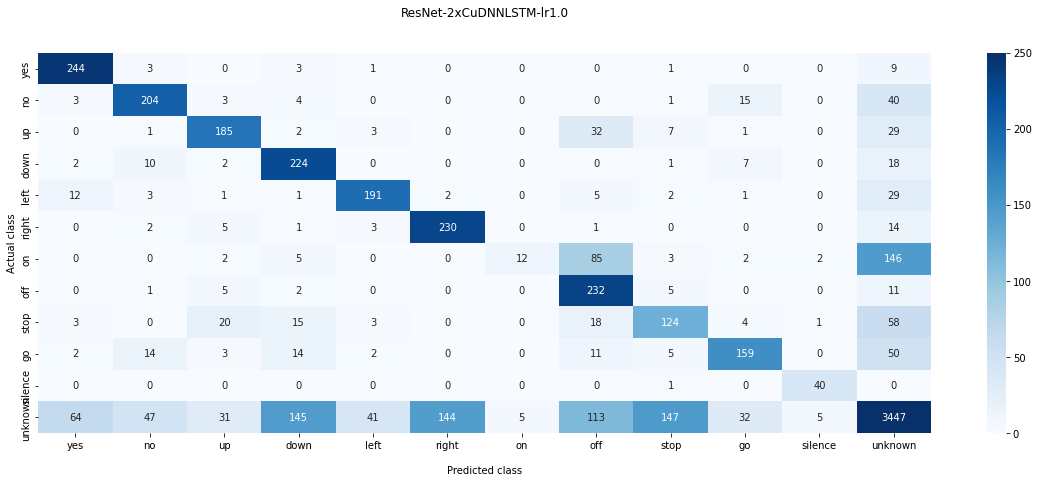

In [93]:
ax = sns.heatmap(cf_mat, annot=cf_mat, fmt='', cmap='Blues', vmin=0, vmax=250)
ax.set_title('ResNet-2xCuDNNLSTM-lr1.0\n\n')
ax.set_xlabel('\nPredicted class')
ax.set_ylabel('Actual class')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()